<a href="https://colab.research.google.com/github/luisfranc123/Tutorials_Statistics_Numerical_Analysis/blob/main/Applied_Statistics/Survival_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Survival Analysis**
---
In this tutorial, we will perform survival analysis on three separate data sets. `BrainCancer`, `Publication`, and a simulated call-center data set.

We begin by importing some of the needed libraries.


In [1]:
%pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 4.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=1d6d9df96c02679124428573c6a5082cfcc9aa47d05562698ebe2d036642c68f
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
from ISLP import load_data

We also collect the new imports needed for this tutorial.

In [3]:
from lifelines import (KaplanMeierFitter, CoxPHFitter)
from lifelines.statistics import (logrank_test, multivariate_logrank_test)
from ISLP.survival import sim_time

###**1. Brain Cancer Data**

We begin with the `BrainCancer` data set, contained in the `ISLP` package.

In [4]:
BrainCancer = load_data('BrainCancer')
BC = BrainCancer.copy()
BC.columns

Index(['sex', 'diagnosis', 'loc', 'ki', 'gtv', 'stereo', 'status', 'time'], dtype='object')

In [5]:
print(BC.sample(10))

       sex   diagnosis             loc   ki    gtv stereo  status   time
48    Male  Meningioma  Supratentorial   70   0.97    SRT       1   1.41
81  Female       Other  Supratentorial   90   1.82    SRT       0  47.11
18    Male  Meningioma  Supratentorial   80  13.49    SRS       1   6.92
5   Female  Meningioma  Supratentorial   80   4.82    SRS       0  52.75
71    Male  Meningioma  Supratentorial   80  20.93    SRT       1  31.15
61    Male  Meningioma  Supratentorial   80  11.51    SRT       1  14.62
77  Female  Meningioma  Supratentorial   90   7.26    SRT       0  49.05
78  Female  Meningioma  Supratentorial  100   9.66    SRT       0  39.25
27    Male   HG glioma  Supratentorial   70  33.69    SRT       1   0.07
82    Male   LG glioma  Infratentorial   90  30.41    SRT       0   1.18


In [6]:
print(f"Number of rows contained within BC: {BC.shape[0]}")
print(f"Number of columns contained within BC: {BC.shape[1]}")

Number of rows contained within BC: 88
Number of columns contained within BC: 8


Therows index the 88 patients, while the 8 columns contain the predictors and outcome variables. We first briefly examine the data.

In [7]:
print(BC['sex'].value_counts())
print("-"*30)
print(f"\n{BC['diagnosis'].value_counts()}")
print("-"*30)
print(f"\n{BC['status'].value_counts()}")

sex
Female    45
Male      43
Name: count, dtype: int64
------------------------------

diagnosis
Meningioma    42
HG glioma     22
Other         14
LG glioma      9
Name: count, dtype: int64
------------------------------

status
0    53
1    35
Name: count, dtype: int64


For the `BrainCancer` data, the `status` variable was coded conventionally, meaning that 35 patients died before the end of the study.

To begin the analysis, we re-create the Kaplan-Meier survival curve.

<Axes: xlabel='timeline'>

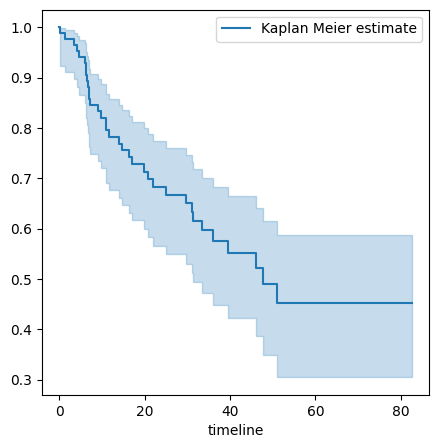

In [8]:
fig, ax = subplots(figsize = (5, 5))
km = KaplanMeierFitter()
km_brain = km.fit(BC['time'], BC['status'])
km_brain.plot(label = 'Kaplan Meier estimate', ax = ax)

Next, we create Kaplan-Meier survival curves that are stratified by `sex`. We do this employing the `groupby()` method.  

/tmp/ipython-input-1894743219.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for sex, df in BC.groupby('sex'):


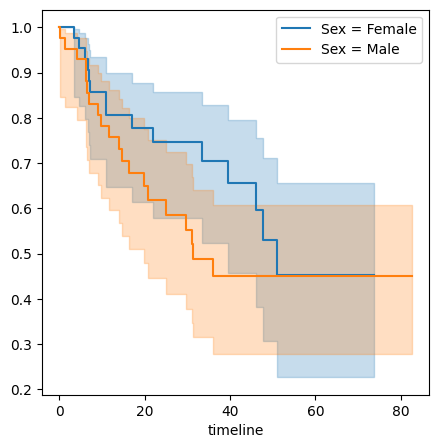

In [9]:
fig, ax = subplots(figsize = (5, 5))
by_sex = {} # empty tuple to store the results
for sex, df in BC.groupby('sex'):
  by_sex[sex] = df
  km_sex = km.fit(df['time'], df['status'])
  km_sex.plot(label = 'Sex = %s' % sex, ax = ax);

We can perform a log-rank test to compare the survival of males to females. We use the `logrank_test()` function from the `lifelines.statistics` module.

In [10]:
print(logrank_test(by_sex['Male']['time'],
             by_sex['Female']['time'],
             by_sex['Male']['status'],
             by_sex['Female']['status']))

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12


**The resulting *p*-value is 0.23, indicating no evidence of a significant difference in survival between males and females.**

Next, we use the `CoxPHFitter()` estimator from `lifelines` to fit Cox proportional hazards models.  We start with a model that considers `sex` as the only predictor.

In [11]:
coxph = CoxPHFitter() # CoxPHFitter object
sex_df = BC[['time', 'status', 'sex']]
model_df = MS(['time', 'status', 'sex'],
              intercept = False).fit_transform(sex_df)
cox_fit = coxph.fit(model_df,
                    'time',
                    'status')
print(cox_fit.summary)
print("-"*80)
print(cox_fit.summary[['coef', 'se(coef)', 'p']])

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
sex[Male]  0.407668   1.503309  0.342004       -0.262648        1.077984   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
sex[Male]             0.769013              2.93875     0.0  1.191998   

                  p  -log2(p)  
covariate                      
sex[Male]  0.233262  2.099977  
--------------------------------------------------------------------------------
               coef  se(coef)         p
covariate                              
sex[Male]  0.407668  0.342004  0.233262


It is possible to obtain the likelihood ratio test comparing this model to the one with no features as follows:

In [12]:
print(cox_fit.log_likelihood_ratio_test())

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12


Regardless of which test we use, we observe that there is no clear evidence for a difference in survival between males and females.

Now we fit a model that includes additional predictors. Before implementing the model including the rest of the features, we clean our data by removing all possible null observations.

In [13]:
cleaned = BC.dropna()
all_MS = MS(cleaned.columns, intercept = False)
all_df = all_MS.fit_transform(cleaned)
fit_all = coxph.fit(all_df,
                    'time',
                    'status'
                    )
print(fit_all.summary)
print('-'*80)
print(fit_all.summary[['coef', 'se(coef)', 'p']])

                           coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                              
sex[Male]              0.183748   1.201712  0.360358       -0.522541   
diagnosis[LG glioma]  -1.239530   0.289520  0.579555       -2.375436   
diagnosis[Meningioma] -2.154566   0.115954  0.450524       -3.037577   
diagnosis[Other]      -1.268870   0.281149  0.617672       -2.479486   
loc[Supratentorial]    0.441195   1.554563  0.703669       -0.937971   
ki                    -0.054955   0.946527  0.018314       -0.090850   
gtv                    0.034293   1.034887  0.022333       -0.009480   
stereo[SRT]            0.177778   1.194560  0.601578       -1.001293   

                       coef upper 95%  exp(coef) lower 95%  \
covariate                                                    
sex[Male]                    0.890036             0.593012   
diagnosis[LG glioma]        -0.103623             0.092974   
diagnosis[Meningioma]       -1.

In [14]:
print(cleaned.diagnosis.unique())

['Meningioma', 'HG glioma', 'LG glioma', 'Other']
Categories (4, object): ['HG glioma', 'LG glioma', 'Meningioma', 'Other']


In [15]:
np.exp(-0.054955)

np.float64(0.9465277407434723)

The `diagnosis` variable has been coded so that the baseline corresponds to HG glioma.

The results indicate that the risk associated with HG glioma is more than 8 times (i.e. $e^{2.15} = 8.62$) the risk associated with meningioma. *In other words, after adjusting for the other predictors, patients with HG glioma have significantly lesser survival probability compared to those with meningioma.* Additionally, larger values of the Karnofsky index, `ki`, (i.e. $e^{-0.054} = 0.95$), are associated with lower risk (longer survival).

Finally, we plot estimated survival curves for each diagnosis category, adjusting for the other predictors. To make these plots, we set the values of the other predictors equal to the mean for quantitative variables and equal to the mode for categorical. To do this, we use the `apply()` method across rows (i.e. `axis=0`) with a function `rep` that checks if a column is categorical or not.

- **hasattr Python built-in function: [hasattr](https://www.geeksforgeeks.org/python/python-hasattr-method/)**


In [16]:
levels = cleaned.diagnosis.unique()

def rep(series):
  if hasattr(series.dtype, 'categories'):
    return pd.Series.mode(series)
  else:
    return series.mean()
model_data = cleaned.apply(rep, axis = 0)

In [17]:
print(model_data)

      sex   diagnosis             loc        ki       gtv stereo    status  \
0  Female  Meningioma  Supratentorial  80.91954  8.687011    SRT  0.402299   

        time  
0  27.188621  


We make fpur copies of the column means and assign the `diagnosis` column to be the four different diagnoses.

In [18]:
model_df = pd.DataFrame(
    [model_data.iloc[0] for _ in range(len(levels))])
model_df['diagnosis'] = levels
print(model_df)

      sex   diagnosis             loc        ki       gtv stereo    status  \
0  Female  Meningioma  Supratentorial  80.91954  8.687011    SRT  0.402299   
0  Female   HG glioma  Supratentorial  80.91954  8.687011    SRT  0.402299   
0  Female   LG glioma  Supratentorial  80.91954  8.687011    SRT  0.402299   
0  Female       Other  Supratentorial  80.91954  8.687011    SRT  0.402299   

        time  
0  27.188621  
0  27.188621  
0  27.188621  
0  27.188621  


We then construct the model matrix based on the model specification `all_MS` used to fit the model, and name the rows according to the levels of `diagnosis`.

In [19]:
model_X = all_MS.transform(model_df)
model_X.index = levels
print(model_X)

            sex[Male]  diagnosis[LG glioma]  diagnosis[Meningioma]  \
Meningioma        0.0                   0.0                    1.0   
HG glioma         0.0                   0.0                    0.0   
LG glioma         0.0                   1.0                    0.0   
Other             0.0                   0.0                    0.0   

            diagnosis[Other]  loc[Supratentorial]        ki       gtv  \
Meningioma               0.0                  1.0  80.91954  8.687011   
HG glioma                0.0                  1.0  80.91954  8.687011   
LG glioma                0.0                  1.0  80.91954  8.687011   
Other                    1.0                  1.0  80.91954  8.687011   

            stereo[SRT]    status       time  
Meningioma          1.0  0.402299  27.188621  
HG glioma           1.0  0.402299  27.188621  
LG glioma           1.0  0.402299  27.188621  
Other               1.0  0.402299  27.188621  


We can use the `predict_survival_function()` method to obtain the estimated survival function.

In [20]:
predicted_survival = fit_all.predict_survival_function(model_X)
print(predicted_survival)

       Meningioma  HG glioma  LG glioma     Other
0.07     0.997947   0.982430   0.994881  0.995029
1.18     0.997947   0.982430   0.994881  0.995029
1.41     0.995679   0.963342   0.989245  0.989555
1.54     0.995679   0.963342   0.989245  0.989555
2.03     0.995679   0.963342   0.989245  0.989555
...           ...        ...        ...       ...
65.02    0.688772   0.040136   0.394181  0.404936
67.38    0.688772   0.040136   0.394181  0.404936
73.74    0.688772   0.040136   0.394181  0.404936
78.75    0.688772   0.040136   0.394181  0.404936
82.56    0.688772   0.040136   0.394181  0.404936

[85 rows x 4 columns]


This return a data frame, whose plot methods yield the different survival curves.

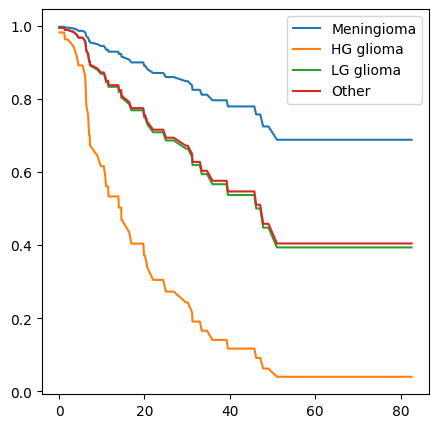

In [21]:
fig, ax = subplots(figsize=(5, 5))
predicted_survival.plot(ax=ax);

###**2. Publication Data**

This data set involves the time to publication of journal papers reporting the results of clinical trials. The covariates include:

- `clinend` $\rightarrow$ whether the study focuses on a clinical endpoint.
- `multi` $\rightarrow$ whether the study involves multiple clinical centers.
- `mech`$\rightarrow$ the funding mechanism.
- `sampsize` $\rightarrow$ sample size.
- `budget` $\rightarrow$ budget (USD)
- `Impact`$\rightarrow$ related to the number of citations.
- `posres`$\rightarrow$ whether the trial produced a positive significant result or a negative result.

The `publication` data can be found in the `ISLP` package. We first re-create the Kaplan-Meier curves stratified on the `posres` (whether the trial produced a positive significant result) variable.  

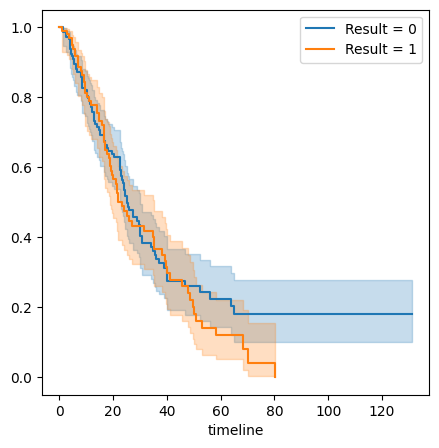

In [22]:
fig, ax = subplots(figsize = (5, 5))
publication = load_data('Publication')
by_result = {} # empty tuple to store the results
for result, df in publication.groupby('posres'):
  by_result[result] = df
  km_result = km.fit(df['time'], df['status'])
  km_result.plot(label = 'Result = %d' % result, ax = ax);

Next, we fit a Cox's proportional hazards model to quantify the difference between survival times in terms of `posres` variable.

In [23]:
posres_df = MS(['posres',
                'time',
                'status'],
               intercept = False).fit_transform(publication)
posres_fit = coxph.fit(posres_df,
                       'time',
                       'status')

print(posres_fit.summary)
print("-"*50)
print(posres_fit.summary[['coef', 'exp(coef)', 'se(coef)', 'p']])

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
posres     0.148076   1.159601  0.161625       -0.168704        0.464856   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
posres                0.844759             1.591785     0.0  0.916168   

                  p  -log2(p)  
covariate                      
posres     0.359579  1.475621  
--------------------------------------------------
               coef  exp(coef)  se(coef)         p
covariate                                         
posres     0.148076   1.159601  0.161625  0.359579


We can observe from the previous results that the *p*-value indicates that there is no significant different between publication times when considering `posres` as the unique covariate.

We know consider additional covariates to assess how the model might change:

In [24]:
publication.columns

Index(['posres', 'multi', 'clinend', 'mech', 'sampsize', 'budget', 'impact',
       'time', 'status'],
      dtype='object')

In [25]:
add_model_df = MS(publication.drop(['mech'], axis = 1),
               intercept = False).fit_transform(publication)
add_model_fit = coxph.fit(add_model_df,
                       'time',
                       'status')
print(add_model_fit.summary)
print("-"*50)
print(add_model_fit.summary[['coef', 'exp(coef)', 'se(coef)', 'p']])

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
posres     0.570773   1.769634  0.175960        0.225898        0.915648   
multi     -0.040860   0.959964  0.251194       -0.533190        0.451470   
clinend    0.546183   1.726650  0.262000        0.032672        1.059694   
sampsize   0.000005   1.000005  0.000015       -0.000024        0.000034   
budget     0.004386   1.004395  0.002465       -0.000445        0.009216   
impact     0.058318   1.060052  0.006676        0.045233        0.071403   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
posres                1.253447             2.498394     0.0  3.243765   
multi                 0.586730             1.570620     0.0 -0.162662   
clinend               1.033212             2.885489     0.0  2.084668   
sampsize              0.99

As we can now observe, the results changed dramatically when we include other predictors in the model. The variables `posres`, `clinend`, and `impact` indicated a statistically significant effect on publication time in this context.

###**3. Call Center Data**

In this section, we will simulate survival data using the relationship between cumulative hazard function.a survival function. The simulated data will represent the observed wiat times (in seconds) for 2000 customers who have contacted a call center. In this context, censoring occurs if a customer hangs up before their call is answered.

There are three covariates: *i)* `Operators` that represent the number of call center operators available at the time of the call, ranging from 5 to 15, *ii)* `Center` which represents three different call centers (A, B or C), and *iii)* `Time` of day (Morning, Afternoon, or Evening).

In [26]:
rng = np.random.default_rng(123) # Seed
N = 2000
operators = rng.choice(np.arange(5, 16),
                       N,
                       replace = True)
center = rng.choice(['A', 'B', 'C'],
                    N,
                    replace = True)
time = rng.choice(['Morning', 'Afternoon', 'Evening'],
                  N,
                  replace = True)
df_cc = pd.DataFrame({'Operators': operators,
                      'Center': pd.Categorical(center),
                      'Time': pd.Categorical(time)})
print(df_cc.sample(10))

      Operators Center       Time
1681         10      A  Afternoon
166           6      C  Afternoon
1749          9      A    Morning
1871         13      A    Evening
1558         13      C    Morning
1727         11      A    Morning
1064          6      C    Evening
939          14      B    Morning
1612         13      B  Afternoon
1456         12      C    Evening


We then build  model matrix:

In [27]:
model_cc = MS(['Operators',
               'Center',
               'Time'],
              intercept = False)
X = model_cc.fit_transform(df_cc)

In [28]:
print(X[:5])

   Operators  Center[B]  Center[C]  Time[Evening]  Time[Morning]
0          5        0.0        0.0            0.0            0.0
1         12        1.0        0.0            0.0            0.0
2         11        0.0        1.0            0.0            0.0
3          5        0.0        0.0            1.0            0.0
4         14        0.0        1.0            1.0            0.0


We now specify the coefficients and the hazard function:

In [29]:
true_beta = np.array([0.04, -0.3, 0., 0.2, -0.2])
true_linpred = X.dot(true_beta)
hazard = lambda t: (1e-5)*t

Here, we have set the coefficient associated with `Operators` to equal 0.04; i.e., each additional operator leads to a $e^{0.04} = 1.041$-fold increase in the "risk" that the cal wil be answered, adjusted for the `Center` and `Time` covariates.

Next, we use the function `sim_time()` from the `ISLP.survival` package. This function uses the relationship between the survival function and cumulative hazard $S(t) = e^{-H(t)}$ and the specific form of the cumulative hazard function in the Cox model to simulate daa based on values of the linear predictor `true_linpred` and the cumulative hazard.

In [30]:
# Cumulative hazard function
cum_hazard = lambda t: (1e-5) * t**2/2

We can now genrate data under the Cox proportional hazards model. The function `sim_time()` ([Module: survival](https://islp.readthedocs.io/en/latest/api/generated/ISLP.survival.html)) takes a linear predictor, a cumulative hazard function, and a random number generator. We truncated the maximum waiting time to 1000 seconds.  

In [31]:
W = np.array([sim_time(l, cum_hazard, rng) for l in true_linpred])
df_cc['Wait_time'] = np.clip(W, 0, 1000)
print(df_cc.sample(10))

      Operators Center       Time   Wait_time
210          10      B    Morning  452.292593
359          15      A    Evening   37.003778
1008          6      B    Evening  418.200629
1330          6      A    Evening  165.635756
1641          6      B    Evening  533.261323
494           8      B    Evening  328.652438
1806          5      A  Afternoon   76.198815
477          13      B    Evening  153.425844
697           5      C    Morning  628.796380
224          12      A    Evening  361.971958


Finally, we simulate the censoring variable, for which it can be assumed that 90% of calls are answred (`Failed == 1`) before customer hung up (`Failed == 0`).

In [32]:
df_cc['Failed'] = rng.choice([1, 0],
                             N,
                             p = [0.9, 0.1])
print(df_cc[:5])

   Operators Center       Time   Wait_time  Failed
0          5      A  Afternoon  326.462155       1
1         12      B  Afternoon  332.843994       1
2         11      C  Afternoon  273.300768       1
3          5      A    Evening  463.642866       1
4         14      C    Evening  231.078447       0


In [33]:
df_cc['Failed'].mean()

np.float64(0.907)

####**Kaplan-Meier survival Curves:**

#####**Stratified by Center:**

/tmp/ipython-input-1494504685.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for center, df in df_cc.groupby('Center'):


Text(0.5, 1.0, 'Probability of Still Being on Hold')

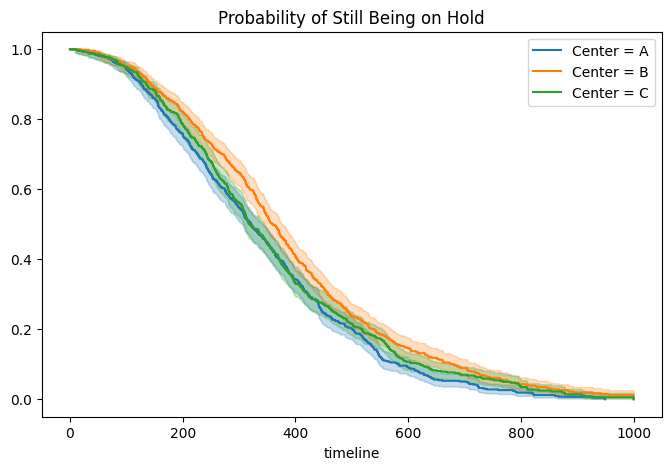

In [34]:
# Stratified by Center
fig, ax = subplots(figsize = (8, 5))
by_center = {} # empty tuple to store the results
for center, df in df_cc.groupby('Center'):
  by_center[center] = df
  km_center = km.fit(df['Wait_time'], df['Failed'])
  km_center.plot(label = 'Center = %s' % center, ax = ax);
ax.set_title("Probability of Still Being on Hold")

#####**Stratified by Time:**

/tmp/ipython-input-2602387839.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for time, df in df_cc.groupby('Time'):


Text(0.5, 1.0, 'Probability of Still Being on Hold')

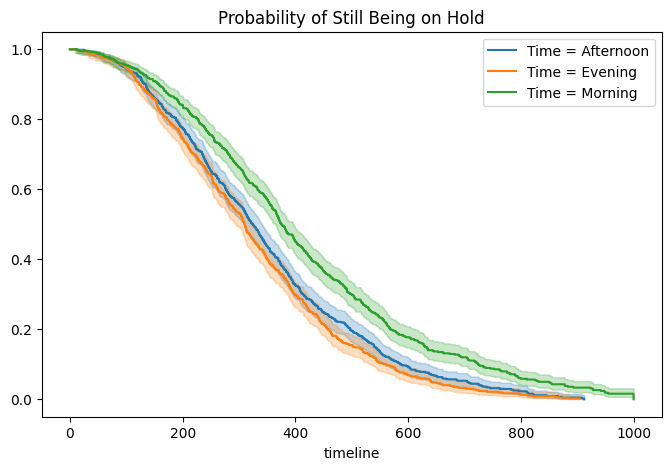

In [35]:
# Stratified by Time
fig, ax = subplots(figsize = (8, 5))
by_time = {} # empty tuple to store the results
for time, df in df_cc.groupby('Time'):
  by_time[time] = df
  km_time = km.fit(df['Wait_time'], df['Failed'])
  km_time.plot(label = 'Time = %s' % time, ax = ax);
ax.set_title("Probability of Still Being on Hold")

Based on the plots above, it seems that at Call Center B take longer to be answered than calls at Centers A and C. Likewise, it appears that wit times are longest in the morning and shortest in the evening hours.

We can now use the log-rank test to determine whether these differences are statistically significant employing the `multivariate_logrank_test()` function.

#####**Log-rank test considering `Centers`:**

In [37]:
print(multivariate_logrank_test(df_cc['Wait_time'],
                          df_cc['Center'],
                          df_cc['Failed']))

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          16.13 <0.005     11.64


#####**Log-rank test considering `Time`:**

In [38]:
print(multivariate_logrank_test(df_cc['Wait_time'],
                          df_cc['Time'],
                          df_cc['Failed']))

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          66.58 <0.005     48.03


As in the case of a categorical variable with 2 levels, these results showcase similarities to the likelihood ratio from the Cox proportional hazards model. First, we look at the results for `Center` variable:

In [41]:
X = MS(['Wait_time', 'Failed', 'Center'],
       intercept = False).fit_transform(df_cc)
F_center = coxph.fit(X, 'Wait_time', 'Failed')
print(F_center.log_likelihood_ratio_test())

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 2
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
          16.19 <0.005     11.68


Next, we look at the results for `Time` variable:

In [42]:
X = MS(['Wait_time', 'Failed', 'Time'],
       intercept = False).fit_transform(df_cc)
F_time = coxph.fit(X, 'Wait_time', 'Failed')
print(F_time.log_likelihood_ratio_test())

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 2
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
          67.64 <0.005     48.79


**We find that differences between centers and times of the day are highly significant.**

Finally, we fit Cox's proportional hazards model to the data.

In [44]:
X = MS(df_cc.columns,
       intercept = False).fit_transform(df_cc)
model_fit = coxph.fit(X,
                      'Wait_time',
                      'Failed')
print(model_fit.summary)
print("-"*50)
print(model_fit.summary[['coef', 'exp(coef)', 'se(coef)', 'p']])

                   coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                      
Operators      0.034194   1.034785  0.007411        0.019668        0.048720   
Center[B]     -0.224564   0.798864  0.057514       -0.337290       -0.111839   
Center[C]     -0.057009   0.944586  0.057635       -0.169970        0.055953   
Time[Evening]  0.116877   1.123981  0.058081        0.003041        0.230713   
Time[Morning] -0.335166   0.715219  0.058305       -0.449442       -0.220889   

               exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                   
Operators                 1.019863             1.049927     0.0  4.613669   
Center[B]                 0.713702             0.894188     0.0 -3.904514   
Center[C]                 0.843690             1.057548     0.0 -0.989141   
Time[Evening]             1.003045             1.25949

The *p*-values for Center B and morning time are significantly small, 9.44e-5 and 9.01e-9, respectively. It is also clear that the hazard -- that is, the instantaneous *"risk"* that a call will be answered -- increases with the number of operators.


